In [8]:
from google.colab import auth
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
from io import BytesIO
from google.cloud import storage
import matplotlib.pyplot as plt
from collections import Counter

# Data Retrieval

In [9]:
auth.authenticate_user()

In [10]:
client = storage.Client()
bucket = client.get_bucket('belkamlbucket')
parquet_files = [blob.name for blob in bucket.list_blobs(prefix='data/raw/') if blob.name.endswith('.parquet')]
print(parquet_files)

['data/raw/test.parquet', 'data/raw/train.parquet']


In [11]:
# # Get training data
# blob = bucket.blob(parquet_files[1])
# data = blob.download_as_bytes()

# Load first row group from the first file as example
blob = bucket.blob(parquet_files[1])
parquet_file = pq.ParquetFile(BytesIO(blob.download_as_bytes()))
table = parquet_file.read_row_group(0)  # read first chunk
df = table.to_pandas()
print(df.head())

   id                            buildingblock1_smiles buildingblock2_smiles  \
0   0  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
1   1  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
2   2  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
3   3  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   
4   4  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  C#CCOc1ccc(CN)cc1.Cl   

     buildingblock3_smiles                                    molecule_smiles  \
0  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
1  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
2  Br.Br.NCC1CCCN1c1cccnn1  C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...   
3        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   
4        Br.NCc1cccc(Br)n1  C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...   

  protein_name  binds  
0       

In [12]:
parquet_file.num_row_groups

282

# Data exploration

In [13]:
# protein_counts = []         # total counts per protein
# protein_bind_counts = []    # binds=0/1 counts per protein
# bind_counts = []            # global binds counts
# smiles_lengths = []         # raw smiles lengths (not describe)

# # Iterate row groups
# for i in range(parquet_file.num_row_groups):
#     table = parquet_file.read_row_group(i)
#     df_chunk = table.to_pandas()

#     # Protein counts (all rows)
#     protein_counts.append(df_chunk['protein_name'].value_counts())

#     # Protein counts split by binds
#     protein_bind_counts.append(df_chunk.groupby(['protein_name', 'binds']).size())

#     # Global binds count
#     bind_counts.append(df_chunk['binds'].value_counts())

#     # Collect raw SMILES lengths
#     smiles_lengths.extend(df_chunk['molecule_smiles'].str.len().tolist())

#     print(f"Processed row group {i+1}/{parquet_file.num_row_groups}")

In [14]:
# # Total counts per protein
# total_protein_counts = pd.concat(protein_counts, axis=1).sum(axis=1).sort_values(ascending=False)

# # Per-protein bind counts
# protein_bind_summary = pd.concat(protein_bind_counts, axis=0).groupby(['protein_name', 'binds']).sum().unstack(fill_value=0)
# protein_bind_summary['total'] = protein_bind_summary.sum(axis=1)
# protein_bind_summary['bind_rate'] = protein_bind_summary[1] / protein_bind_summary['total']

# # Global bind balance
# total_bind_counts = pd.concat(bind_counts, axis=1).sum(axis=1)

# # SMILES lengths as raw distribution
# smiles_lengths = pd.Series(smiles_lengths)

# # --- Print summaries ---
# print("Molecule counts per protein:\n", total_protein_counts.head())
# print("\nGlobal binds distribution:\n", total_bind_counts)
# print("\nProtein bind summary (first few):\n", protein_bind_summary.head())
# print("\nSMILES length summary:\n", smiles_lengths.describe())


In [15]:
# # Protein distribution
# total_protein_counts.plot(kind='bar', figsize=(12,5))
# plt.title("Molecule counts per protein")
# plt.ylabel("Count")
# plt.show()

# # Global binds balance
# total_bind_counts.plot(kind='bar', figsize=(6,4))
# plt.title("Bind vs Non-Bind Counts")
# plt.xlabel("binds")
# plt.ylabel("Count")
# plt.show()

# # SMILES lengths
# plt.hist(smiles_lengths, bins=50)
# plt.title("Distribution of molecule SMILES lengths")
# plt.xlabel("SMILES length")
# plt.ylabel("Frequency")
# plt.show()

# # Bind rate per protein
# protein_bind_summary['bind_rate'].sort_values(ascending=False).plot(kind='bar', figsize=(12,5))
# plt.title("Bind Rate per Protein")
# plt.ylabel("Proportion of bind=1")
# plt.show()

In [16]:
protein_counts = Counter()         # total counts per protein
protein_bind_counts = Counter()    # (protein, bind) counts
bind_counts = Counter()            # global binds counts
smiles_length_counts = Counter()   # histogram of SMILES lengths

# Iterate row groups
for i in range(parquet_file.num_row_groups):
    table = parquet_file.read_row_group(i)
    df_chunk = table.to_pandas()

    # Protein counts
    protein_counts.update(df_chunk['protein_name'])

    # Protein x binds counts
    protein_bind_counts.update(zip(df_chunk['protein_name'], df_chunk['binds']))

    # Global bind counts
    bind_counts.update(df_chunk['binds'])

    # Histogram of SMILES lengths (instead of storing all values)
    smiles_length_counts.update(df_chunk['molecule_smiles'].str.len())

    if (i+1) % 10 == 0:  # print progress every 10 groups
        print(f"Processed row group {i+1}/{parquet_file.num_row_groups}")

Processed row group 10/282
Processed row group 20/282
Processed row group 30/282
Processed row group 40/282
Processed row group 50/282
Processed row group 60/282
Processed row group 70/282
Processed row group 80/282
Processed row group 90/282
Processed row group 100/282
Processed row group 110/282
Processed row group 120/282
Processed row group 130/282
Processed row group 140/282
Processed row group 150/282
Processed row group 160/282
Processed row group 170/282
Processed row group 180/282
Processed row group 190/282
Processed row group 200/282
Processed row group 210/282
Processed row group 220/282
Processed row group 230/282
Processed row group 240/282
Processed row group 250/282
Processed row group 260/282
Processed row group 270/282
Processed row group 280/282


In [17]:
# Protein totals
total_protein_counts = pd.Series(protein_counts).sort_values(ascending=False)

# Per-protein bind counts
protein_bind_df = pd.DataFrame.from_dict(protein_bind_counts, orient='index', columns=['count'])
protein_bind_df.index = pd.MultiIndex.from_tuples(protein_bind_df.index, names=['protein_name', 'binds'])
protein_bind_summary = protein_bind_df['count'].unstack(fill_value=0)
protein_bind_summary['total'] = protein_bind_summary.sum(axis=1)
protein_bind_summary['bind_rate'] = protein_bind_summary[1] / protein_bind_summary['total']

# Global binds
total_bind_counts = pd.Series(bind_counts).sort_index()

# SMILES length distribution
smiles_length_series = pd.Series(smiles_length_counts)


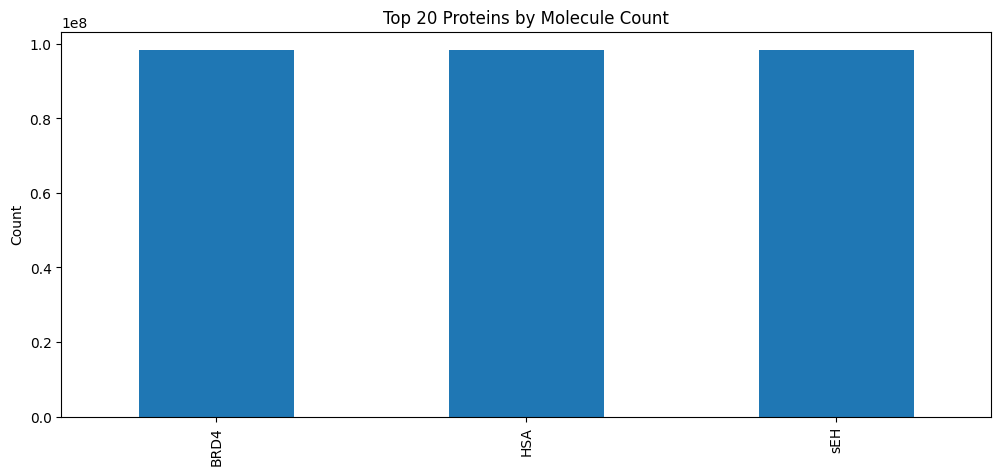

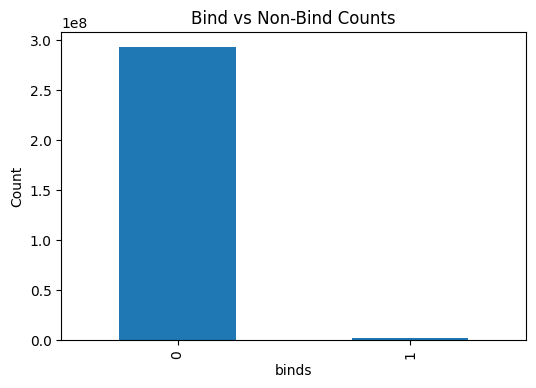

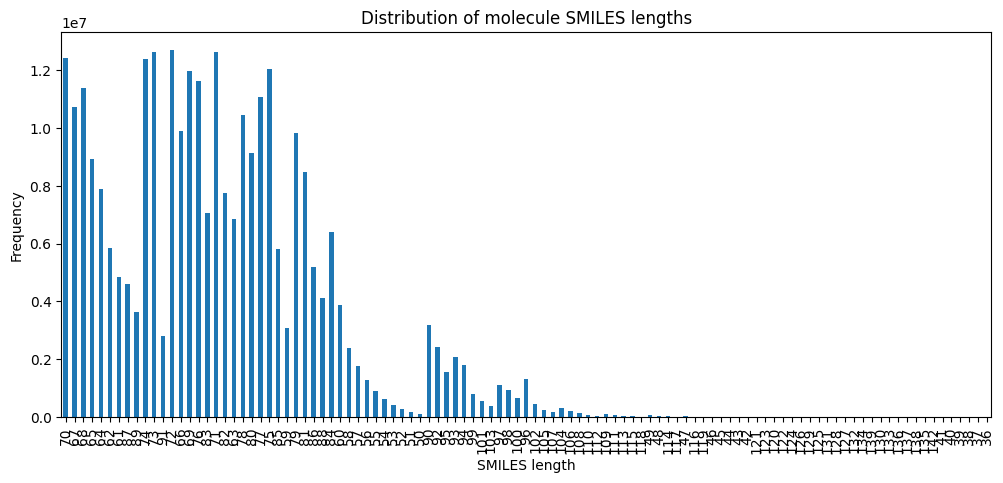

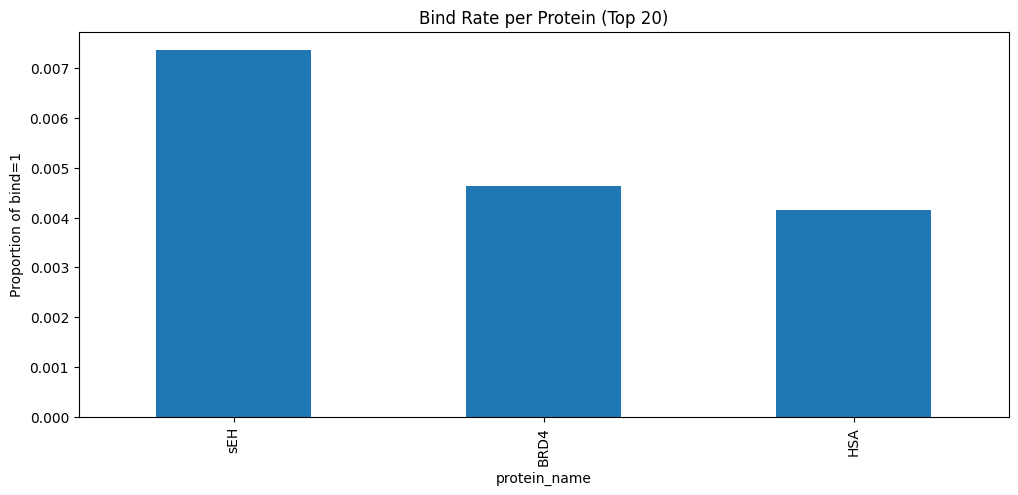

In [18]:
import matplotlib.pyplot as plt

# Protein distribution
total_protein_counts.head(20).plot(kind='bar', figsize=(12,5))  # top 20
plt.title("Top 20 Proteins by Molecule Count")
plt.ylabel("Count")
plt.show()

# Global binds balance
total_bind_counts.plot(kind='bar', figsize=(6,4))
plt.title("Bind vs Non-Bind Counts")
plt.xlabel("binds")
plt.ylabel("Count")
plt.show()

# Histogram of SMILES lengths
smiles_length_series.plot(kind='bar', figsize=(12,5))
plt.title("Distribution of molecule SMILES lengths")
plt.xlabel("SMILES length")
plt.ylabel("Frequency")
plt.show()

# Bind rate per protein
protein_bind_summary['bind_rate'].sort_values(ascending=False).head(20).plot(kind='bar', figsize=(12,5))
plt.title("Bind Rate per Protein (Top 20)")
plt.ylabel("Proportion of bind=1")
plt.show()


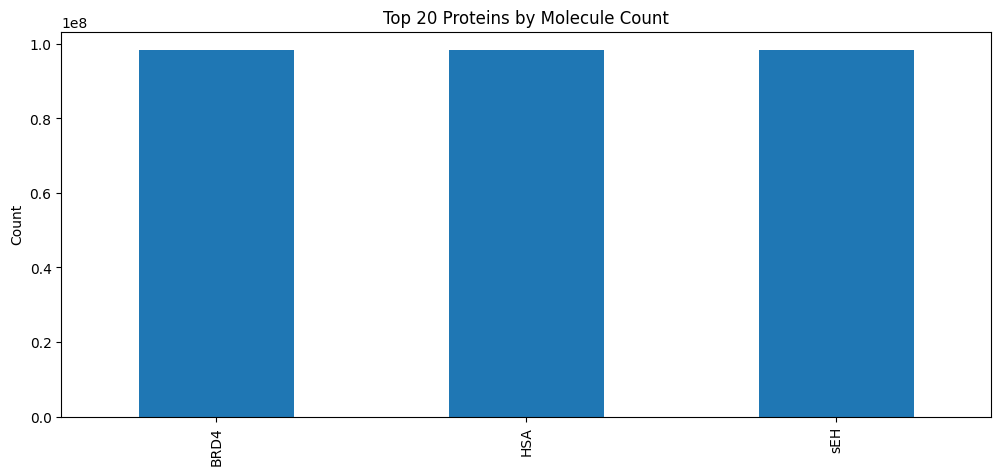

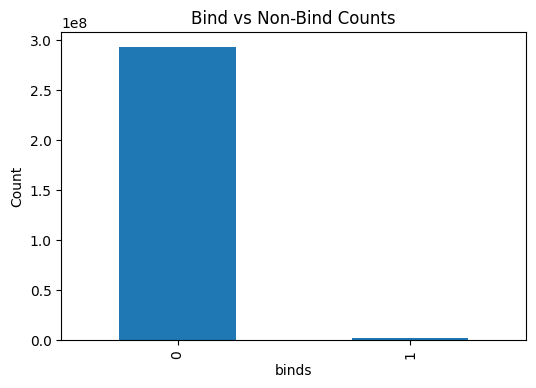

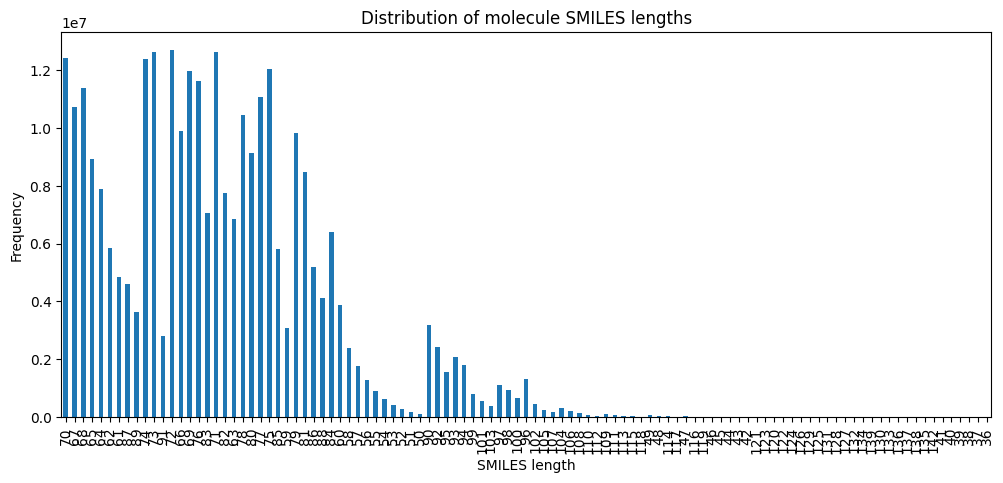

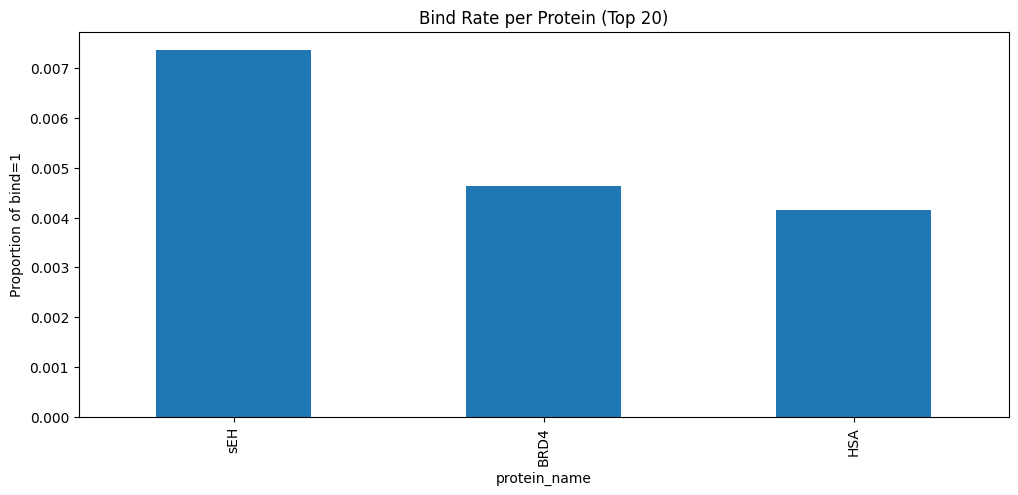

In [19]:
import matplotlib.pyplot as plt

# Protein distribution
total_protein_counts.head(20).plot(kind='bar', figsize=(12,5))
plt.title("Top 20 Proteins by Molecule Count")
plt.ylabel("Count")
plt.savefig("top_20_proteins.png")  # Saves as PNG
plt.show()

# Global binds balance
total_bind_counts.plot(kind='bar', figsize=(6,4))
plt.title("Bind vs Non-Bind Counts")
plt.xlabel("binds")
plt.ylabel("Count")
plt.savefig("bind_vs_nonbind.png")
plt.show()

# Histogram of SMILES lengths
smiles_length_series.plot(kind='bar', figsize=(12,5))
plt.title("Distribution of molecule SMILES lengths")
plt.xlabel("SMILES length")
plt.ylabel("Frequency")
plt.savefig("smiles_length_distribution.png")
plt.show()

# Bind rate per protein
protein_bind_summary['bind_rate'].sort_values(ascending=False).head(20).plot(kind='bar', figsize=(12,5))
plt.title("Bind Rate per Protein (Top 20)")
plt.ylabel("Proportion of bind=1")
plt.savefig("top_20_bind_rate.png")
plt.show()
